In [26]:
# imports and loading
from pymodulon.io import *
from pymodulon.plotting import *
from scipy.stats import fisher_exact, chi2_contingency
from statsmodels.stats.multitest import multipletests
from os import path
import seaborn as sns

data_dir = path.join('..','data','processed_data')
interim_dir = path.join('..','data','interim')
ica_data = load_json_model(path.join(interim_dir,'zmo_raw.json.gz'))

# let's create a metadata enrichment function
def metadata_enrichment(ica_data, iM, categories = ['project','gene_KO', 'Strain Description', 'Evolved Sample', 'Base Media', 'Temperature (C)', 'pH', 'Carbon Source (g/L)', 'Supplement', 'Growth Rate (1/hr)', 'Isolate Type', 'lab', 'Aerobicity']):
    # first let's find the samples where the iM is active
    vals = abs(ica_data.A.loc[iM].values)
    avg = np.mean(vals)
    std = np.std(vals)
    active_samps = ica_data.A.columns[vals > (avg + 2*std)]
    samp_table = ica_data.sample_table.fillna('nan')
    samp_table['is_active'] = samp_table.index.isin(active_samps)
    
    # now enrichment against the categories
    return_dfs = []
    for cat in categories:
        # try each type of category found in the active samples
        contingency_table = pd.crosstab(samp_table[cat], samp_table['is_active'])
        _, pval, dof, expected = chi2_contingency(contingency_table)
        observed = contingency_table.values
        observed_df = pd.DataFrame(observed, index=contingency_table.index, columns=contingency_table.columns)
        residuals = (observed - expected) / (expected ** 0.5)
        residuals_df = pd.DataFrame(residuals, index=contingency_table.index, columns=contingency_table.columns)
        most_abnormal = abs(residuals_df).sort_values(by = True, ascending = False).index[0]
        
        # calculate precision and recall of most abnormal
        true_pos = observed_df.loc[most_abnormal][True]
        false_pos = observed_df.loc[most_abnormal][False]
        false_neg = observed_df[True].sum() - true_pos
        precision = true_pos / (true_pos + false_pos)
        recall = true_pos / (true_pos + false_neg)
        
        return_dfs.append([cat, pval, most_abnormal, precision, recall])
    
    output_df = pd.DataFrame(return_dfs, columns = ['Category', 'p_value', 'most_enriched', 'precision', 'recall'])
    _, q_values, _, _ = multipletests(output_df['p_value'], method='fdr_bh')
    output_df['q_value'] = q_values
    output_df = output_df.set_index('Category').sort_values(by = 'p_value')[['p_value', 'q_value', 'most_enriched', 'precision', 'recall']]
    
    return(output_df)


# gene table enrichment
def genes_enrichment(ica_data, iM, categories = ['strand', 'gene_product', 'COG', 'operon', 'chromosome_id']):
    # first let's find the samples where the iM is active
    vals = abs(ica_data.A.loc[iM].values)
    avg = np.mean(vals)
    std = np.std(vals)
    active_samps = ica_data.view_imodulon(iM).index
    samp_table = ica_data.gene_table.fillna('nan')
    samp_table['is_active'] = samp_table.index.isin(active_samps)
    
    # now enrichment against the categories
    return_dfs = []
    for cat in categories:
        # try each type of category found in the active samples
        contingency_table = pd.crosstab(samp_table[cat], samp_table['is_active'])
        _, pval, dof, expected = chi2_contingency(contingency_table)
        observed = contingency_table.values
        observed_df = pd.DataFrame(observed, index=contingency_table.index, columns=contingency_table.columns)
        residuals = (observed - expected) / (expected ** 0.5)
        residuals_df = pd.DataFrame(residuals, index=contingency_table.index, columns=contingency_table.columns)
        most_abnormal = abs(residuals_df).sort_values(by = True, ascending = False).index[0]
        
        # calculate precision and recall of most abnormal
        true_pos = observed_df.loc[most_abnormal][True]
        false_pos = observed_df.loc[most_abnormal][False]
        false_neg = observed_df[True].sum() - true_pos
        precision = true_pos / (true_pos + false_pos)
        recall = true_pos / (true_pos + false_neg)
        
        return_dfs.append([cat, pval, most_abnormal, precision, recall])
    
    output_df = pd.DataFrame(return_dfs, columns = ['Category', 'p_value', 'most_enriched', 'precision', 'recall'])
    _, q_values, _, _ = multipletests(output_df['p_value'], method='fdr_bh')
    output_df['q_value'] = q_values
    output_df = output_df.set_index('Category').sort_values(by = 'p_value')[['p_value', 'q_value', 'most_enriched', 'precision', 'recall']]
    
    return(output_df)


def custom_plot_gene_weights(ica_data, imodulon, by="start", xaxis=None, xname="", **kwargs):
    """
    Plot gene weights on a scatter plot.

    Parameters
    ----------
    ica_data: ~pymodulon.core.IcaData
        :class:`~pymodulon.core.IcaData` object
    imodulon : int or str
        `iModulon` name
    by: 'log-tpm-norm', 'length', or 'start'
        Property to plot on x-axis. Superceded by `xaxis`
    xaxis: list, dict or ~pandas.Series, optional
        Values on custom x-axis
    xname: str, optional
        Name of x-axis if using custom x-axis
    **kwargs:
        Additional keyword arguments passed to :func:`pymodulon.plotting.scatterplot`
    Returns
    -------
    ax: ~matplotlib.axes.Axes
        :class:`~matplotlib.axes.Axes` containing the scatterplot
    """
    # Check that iModulon exists
    if imodulon in ica_data.M.columns:
        y = ica_data.M[imodulon]
        ylabel = f"{imodulon} Gene Weight"
    else:
        raise ValueError(f"iModulon does not exist: {imodulon}")

    # Get genes in the iModulon
    bin_M = ica_data.M_binarized
    component_genes = set(bin_M[imodulon].loc[bin_M[imodulon] == 1].index)
    other_genes = set(bin_M[imodulon].loc[bin_M[imodulon] == 0].index)

    # If experimental `xaxis` parameter is used, use custom values for x-axis
    if xaxis is not None:
        x = _set_xaxis(xaxis=xaxis, y=y)
        xlabel = xname

    else:
        #  Ensure 'by' has a valid input and assign x, xlabel accordingly
        if by == "log-tpm":
            x = ica_data.log_tpm.mean(axis=1)
            xlabel = "Mean Expression"
        elif by == "log-tpm-norm":
            x = ica_data.X.mean(axis=1)
            xlabel = "Mean Centered Expression"
        elif by == "length":
            x = np.log10(ica_data.gene_table.length)
            xlabel = "Gene Length (log10-scale)"
        elif by == "start":
            x = ica_data.gene_table.start
            xlabel = "Gene Start"
        else:
            raise ValueError(
                '"by" must be "log-tpm", "log-tpm-norm", "length", ' 'or "start"'
            )

    # Override specific kwargs (their implementation is different
    # in this function)
    show_labels_pgw = kwargs.pop("show_labels", "auto")
    adjust_labels_pgw = kwargs.pop("adjust_labels", True)
    legend_kwargs_pgw = kwargs.pop("legend_kwargs", {})
    label_font_kwargs_pgw = kwargs.pop("label_font_kwargs", {})

    kwargs["show_labels"] = kwargs["adjust_labels"] = False

    # Remove xlabel and ylabel kwargs if provided
    kwargs.pop("xlabel", None)
    kwargs.pop("ylabel", None)

    # Default legend should be on the side of the plot
    if (
        "bbox_to_anchor" not in legend_kwargs_pgw.keys()
        and "loc" not in legend_kwargs_pgw.keys()
    ):
        legend_kwargs_pgw.update({"bbox_to_anchor": (1, 1), "loc": 2})
        kwargs["legend_kwargs"] = legend_kwargs_pgw

    # Update colors for COG groups
    if "COG" in ica_data.gene_table.columns and "groups" not in kwargs:
        mod_cogs = ica_data.gene_table.loc[component_genes].COG
        hidden_cogs = pd.Series("hidden", index=other_genes)
        all_cogs = pd.concat([mod_cogs, hidden_cogs])
        # colors = {cog:ica_data.cog_colors[cog] for cog in sorted(mod_cogs.unique())}
        kwargs.update({"groups": all_cogs, "colors": ica_data.cog_colors})

    # Scatter Plot
    ax = scatterplot(x, y, xlabel=xlabel, ylabel=ylabel, **kwargs)
    
    # add vertical lines at chromosome changes
    for grp in ica_data.gene_table.groupby('chromosome_id'):
        plt.axvline(x = max(grp[1].fillna(0).end), ls = '--', c = 'k')

    # Add thresholds to scatter-plot (dashed lines)
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    thresh = ica_data.thresholds[imodulon]
    if thresh != 0:
        ax.hlines(
            [thresh, -thresh],
            xmin=xmin,
            xmax=xmax,
            colors="k",
            linestyles="dashed",
            linewidth=1,
        )

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    texts = []
    expand_kwargs = {"expand_objects": (1.2, 1.4), "expand_points": (1.3, 1.3)}

    # Add labels: Put gene name if components contain under 20 genes
    if show_labels_pgw is True or (
        show_labels_pgw is not False and len(component_genes) <= 20
    ):
        for gene in component_genes:

            # Add labels
            text_kwargs = label_font_kwargs_pgw.copy()

            if "fontstyle" not in text_kwargs:
                text_kwargs.update({"fontstyle": "normal"})

            # Italicize gene if there is a defined name (not locus tag)
            try:
                gene_name = ica_data.gene_table.loc[gene, "gene_name"]

                if gene_name != gene:
                    text_kwargs.update({"fontstyle": "italic"})

            except KeyError:
                gene_name = gene

            # Set default fontsize
            if "fontsize" not in text_kwargs:
                text_kwargs.update({"fontsize": 12})

            texts.append(
                ax.text(
                    x[gene],
                    ica_data.M.loc[gene, imodulon],
                    gene_name,
                    **text_kwargs,
                )
            )

        expand_kwargs["expand_text"] = (1.4, 1.4)

    # Add labels: Repel texts from other text and points
    rect = ax.add_patch(
        Rectangle(
            xy=(xmin, -abs(thresh)),
            width=xmax - xmin,
            height=2 * abs(thresh),
            fill=False,
            linewidth=0,
        )
    )

    if adjust_labels_pgw:
        adjust_text(
            texts=texts,
            add_objects=[rect],
            ax=ax,
            arrowprops=dict(arrowstyle="-", color="k", lw=0.5),
            only_move={"objects": "y"},
            **expand_kwargs,
        )

    return ax

# investgiate an iM

In [32]:
iM_ct = 'nitrogen_fixation'

In [33]:
pd.set_option('display.max_rows', 500)
impt_cols = ['gene_name', 'gene_weight', 'gene_product', 'COG', 'EC_number']
df = ica_data.view_imodulon(iM_ct).sort_values(by = 'gene_weight', ascending = False, key = abs)
df[impt_cols]

,gene_name,gene_weight,gene_product,COG,EC_number
ZCP4_1354,ZCP4_1354,0.307049,Mo-nitrogenase MoFe protein subunit NifD precu...,Energy production and conversion,1.18.6.1
ZCP4_1355,nifH,0.298938,Mo-nitrogenase iron protein subunit NifH,"Cell cycle control, cell division, chromosome ...","1.18.6.1,1.3.7.7"
ZCP4_1353,ZCP4_1353,0.276871,Mo-nitrogenase MoFe protein subunit NifK,Energy production and conversion,1.18.6.1
ZCP4_1351,ZCP4_1351,0.227765,nitrogenase molybdenum-iron cofactor biosynthe...,Coenzyme transport and metabolism,NaN
ZCP4_1349,ZCP4_1349,0.222304,putative nitrogen fixation protein,Function unknown,NaN
ZCP4_1352,ZCP4_1352,0.221687,nitrogenase molybdenum-iron cofactor biosynthe...,Energy production and conversion,NaN
ZCP4_1346,ZCP4_1346,0.209056,Iron-sulfur cluster assembly accessory protein,Function unknown,NaN
ZCP4_1350,ZCP4_1350,0.196051,nitrogen fixation protein NifX,Function unknown,NaN
ZCP4_1348,ZCP4_1348,0.186421,ferredoxin III%2C nif-specific,Energy production and conversion,NaN
ZCP4_1344,ZCP4_1344,0.138938,cysteine desulfurase NifS,Coenzyme transport and metabolism,2.8.1.7


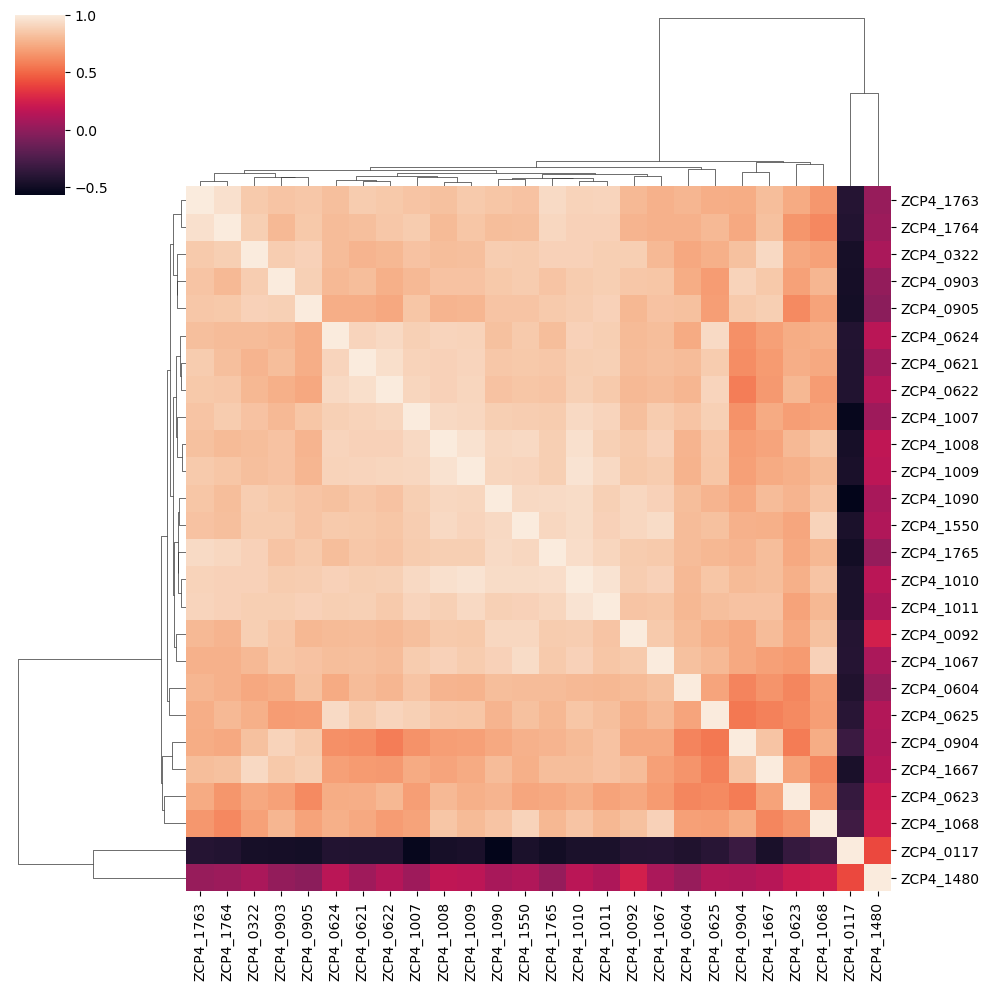

In [29]:
df = ica_data.X.loc[ica_data.view_imodulon(iM_ct).index]
sns.clustermap(df.T.corr())
plt.show()

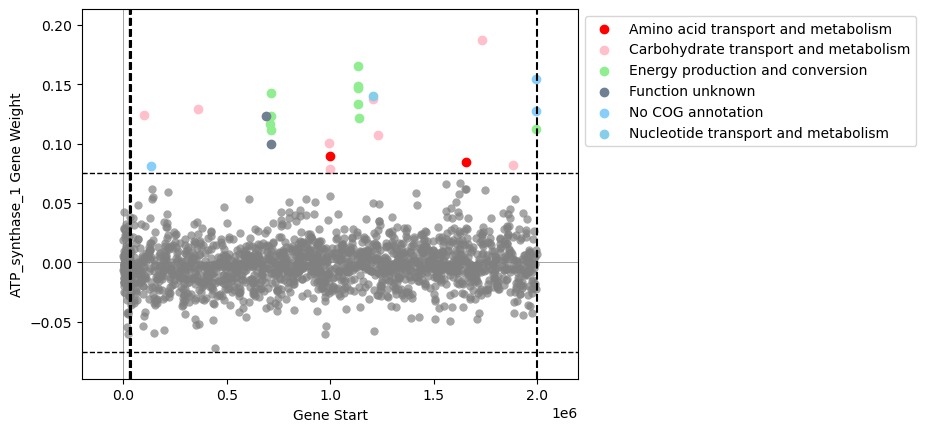

In [30]:
custom_plot_gene_weights(ica_data, iM_ct)
plt.show()

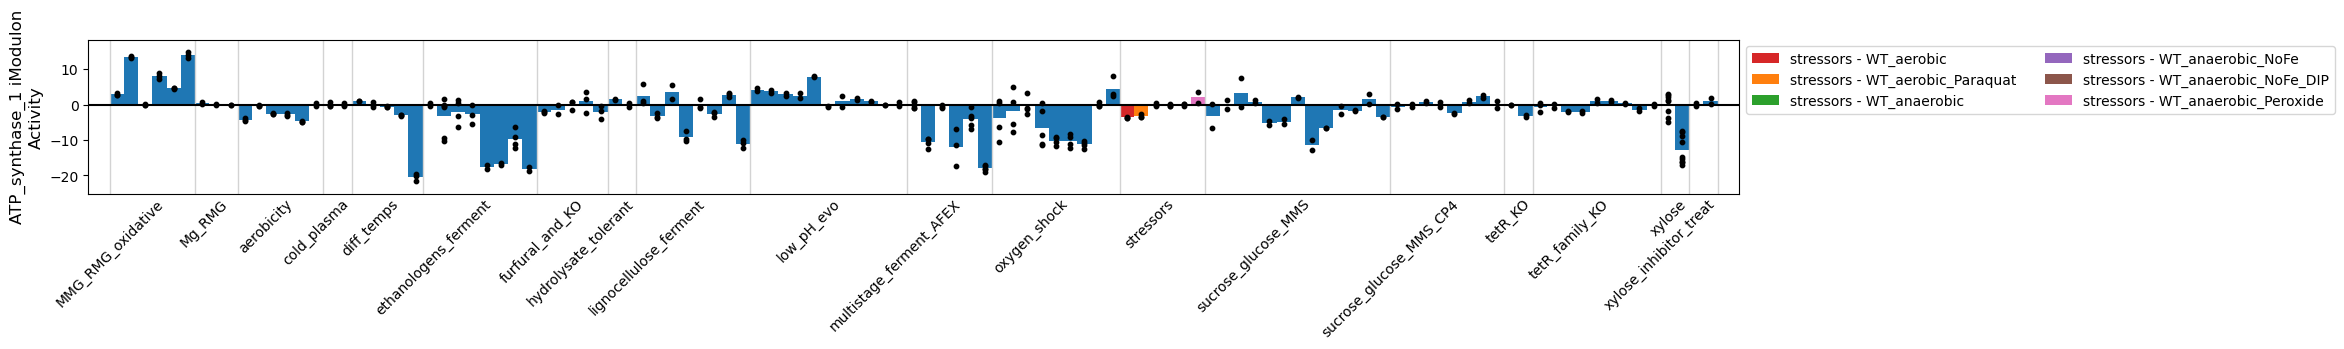

In [31]:
plot_activities(ica_data, iM_ct, highlight=['stressors'])#'low_pH_evo'])
plt.show()

In [6]:
out = metadata_enrichment(ica_data, iM_ct)
out[out['q_value'] < 0.10]

,p_value,q_value,most_enriched,precision,recall
Category,,,,,
pH,4.301394e-14,5.591812e-13,3.8,0.700000,0.333333
Supplement,4.495310e-07,2.921952e-06,MMS (15 mM),1.000000,0.095238
Evolved Sample,9.423823e-06,4.083656e-05,yes,0.318182,0.333333
Isolate Type,2.418104e-05,7.858839e-05,size fractionation,0.318182,0.333333
project,1.314885e-04,3.418701e-04,low_pH_evo,0.318182,0.333333
Growth Rate (1/hr),1.558048e-03,3.375770e-03,OD 1.5 / stationary,1.000000,0.095238
Strain Description,2.143585e-03,3.980943e-03,Zymomonas mobilis subsp. mobilis str. CP4 = NR...,0.250000,0.190476
Temperature (C),1.024664e-02,1.665078e-02,30.0,0.008130,0.047619
Carbon Source (g/L),6.707369e-02,9.688421e-02,glucose(2%),0.184211,0.333333


In [7]:
out = genes_enrichment(ica_data, iM_ct)
out[out['q_value'] < 0.10]

,p_value,q_value,most_enriched,precision,recall
Category,,,,,


# below is as forked from SBRG/iModulonMiner, ignoring it for now

## Add iModulon category

In [7]:
for i,row in ica_data.imodulon_table.iterrows():
    if pd.notnull(row.regulator):
        ica_data.imodulon_table.loc[i, 'category'] = 'regulatory'
    elif pd.notnull(row.single_gene):
        ica_data.imodulon_table.loc[i, 'category'] = 'single_gene'
    else:
        ica_data.imodulon_table.loc[i, 'category'] = 'uncharacterized'

AttributeError: 'Series' object has no attribute 'regulator'

In [6]:
ica_data.imodulon_table.head()

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs,single_gene,explained_variance,category
S-box,S-box,1.436720e-30,8.620321e-30,0.652174,0.576923,0.612245,15.0,26.0,23,1.0,NaN,0.010646,regulatory
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87,NaN,NaN,0.006978,uncharacterized
WalR,WalR,1.897147e-12,2.656006e-11,0.388889,0.291667,0.333333,7.0,24.0,18,1.0,NaN,0.003324,regulatory
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,152,NaN,NaN,0.001433,uncharacterized
Rex,Rex,1.416977e-19,7.084883e-19,1.000000,0.583333,0.736842,7.0,12.0,7,1.0,NaN,0.004055,regulatory


## Inspect all iModulons without an automated annotation

In [8]:
unchar_imods = ica_data.imodulon_table[ica_data.imodulon_table.category == 'uncharacterized']

AttributeError: 'DataFrame' object has no attribute 'category'

In [9]:
unchar_imods

NameError: name 'unchar_imods' is not defined

### iModulon 1: Unknown

In [10]:
ica_data.view_imodulon(1)

,gene_weight,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,uniprot,operon
ZCP4_0174,0.604033,ZCP4_0174,CP006818.1,NaN,201072.0,201167.0,-,hypothetical protein,No COG annotation,NaN,Op312


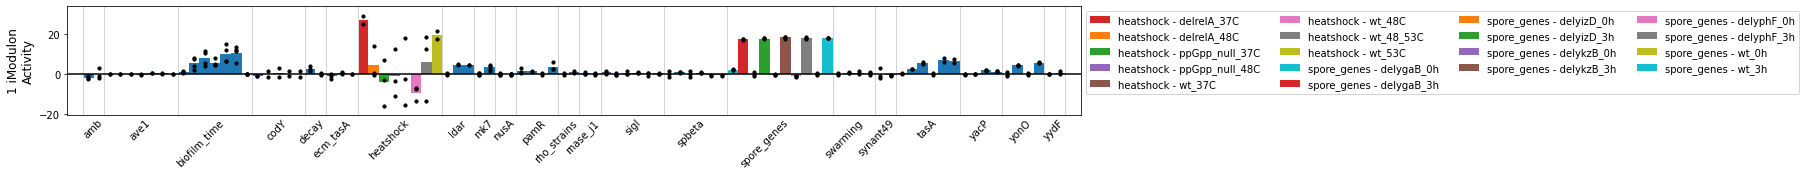

In [10]:
plot_activities(ica_data,1,highlight=['heatshock','spore_genes'])

In [11]:
DF_enrichments[DF_enrichments.imodulon=='1'].sort_values('f1score',ascending=False)

,imodulon,annotation,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,source,kegg_id,pathway_name,module_name,value


In [12]:
# Update the ICA data object

ica_data.rename_imodulons({1:'uncharacterized-1'})

### iModulon 3: Unknown
This iModulon is likely some technical artifact from the MK7 project.

In [13]:
ica_data.view_imodulon(3)

,gene_weight,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,uniprot,operon,regulator
BSU_00220,0.074081,yaaL,AL009126.3,BSU00220,29481,29705,+,conserved protein of unknown function,Function unknown,P37533,Op15,NaN
BSU_01790,0.146841,ybbU,AL009126.3,BSU01790,202126,202266,+,hypothetical protein,No COG annotation,A0A2K4Z9G0,Op134,NaN
BSU_01920,0.038189,skfB,AL009126.3,BSU01920,214175,215407,+,synthesis of sporulation killing factor A,"Translation, ribosomal structure and biogenesis",O31423,Op145,"Spo0A,SigA,PhoP,AbrB"
BSU_02000,-0.045146,ybdJ,AL009126.3,BSU02000,221258,221929,+,two-component system response regulator [YbdK],Signal transduction mechanisms,O31432,Op147,NaN
BSU_02220,-0.052457,ybfI,AL009126.3,BSU02220,242834,243661,-,putative transcriptional regulator (AraC/XylS ...,Transcription,O31449,Op168,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
BSU_40160,-0.107328,liaK,AL009126.3,BSU40160,4125742,4126500,-,membrane metalloprotease acting on modified fa...,"Post-translational modification, protein turno...",Q45594,Op3080,"Rok,SigA,AbrB"
BSU_40460,0.113660,yyzB,AL009126.3,BSU40460,4159253,4159456,-,conserved protein of unknown function,No COG annotation,O32296,Op3102,NaN
BSU_40574,0.072859,yyzJ,AL009126.3,NaN,4171625,4171789,-,hypothetical protein,Function unknown,NaN,Op3113,NaN
BSU_40610,0.041476,yybK,AL009126.3,BSU40610,4175117,4175872,+,putative transporter permease subunit,Function unknown,P37493,Op3117,"Rok,DnaA"


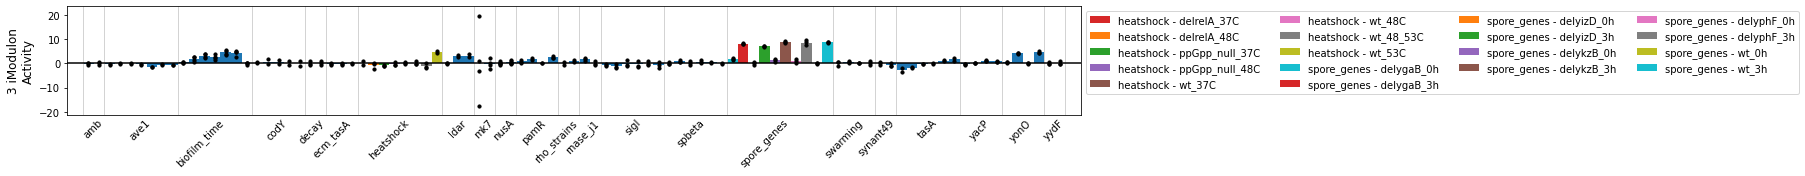

In [14]:
plot_activities(ica_data,3,highlight=['heatshock','spore_genes'])

In [15]:
DF_enrichments[DF_enrichments.imodulon=='3'].sort_values('f1score',ascending=False)

,imodulon,annotation,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,source,kegg_id,pathway_name,module_name,value
16,3,NaN,0.000319,0.041976,0.151316,0.075658,0.100877,23.0,304.0,152.0,NaN,NaN,NaN,NaN,Prophages and mobile genetic elements
15,3,NaN,0.000004,0.001035,0.065789,0.212766,0.100503,10.0,47.0,152.0,NaN,NaN,NaN,NaN,pseudogenes
17,3,NaN,0.000440,0.041976,0.144737,0.075601,0.099323,22.0,291.0,152.0,NaN,NaN,NaN,NaN,prophages


In [16]:
# Update the ica_data object
ica_data.rename_imodulons({3:'uncharacterized-2'})

### iModulon 6: ybc Operon
This iModulon contains four genes starting with ybc, and ndhF, which are all likely in the same operon. Little is known about the genes except that they are part of prophage 1.

In [17]:
ica_data.view_imodulon(6)

,gene_weight,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,uniprot,operon,regulator
BSU_01830,0.272368,ndhF,AL009126.3,BSU01830,205409,206926,+,putative NADH dehydrogenase%3B prophage 1 region,Energy production and conversion,P39755,Op137,NaN
BSU_01845,0.265787,ybcC,AL009126.3,BSU01845,206941,209556,+,conserved transmembrane protein coupled to NAD...,Function unknown,O34688,Op138,NaN
BSU_01860,0.254484,ybcF,AL009126.3,BSU01860,209633,210160,+,putative enzyme%3B prophage 1 region,Inorganic ion transport and metabolism,O34823,Op139,NaN
BSU_01870,0.260051,ybcH,AL009126.3,BSU01870,210224,210514,+,conserved protein of unknown function%3B proph...,No COG annotation,O34795,Op140,NaN
BSU_01880,0.199487,ybcI,AL009126.3,BSU01880,210572,210946,+,conserved hypothetical protein%3B prophage 1 r...,Function unknown,O34380,Op141,NaN


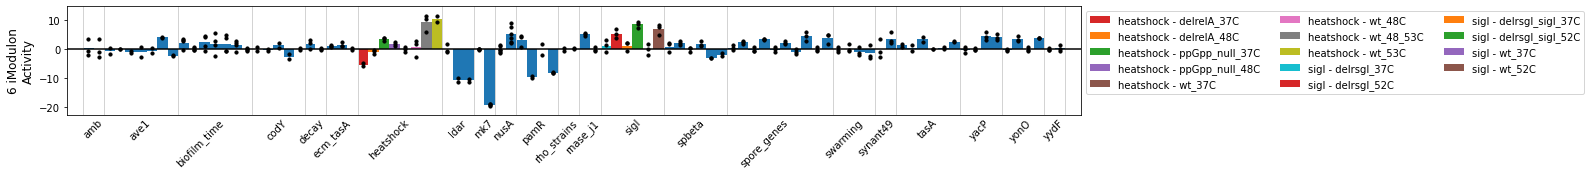

In [18]:
plot_activities(ica_data,6,highlight=['heatshock','sigI'])

In [19]:
DF_enrichments[DF_enrichments.imodulon=='6'].sort_values('f1score',ascending=False)

,imodulon,annotation,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,source,kegg_id,pathway_name,module_name,value


In [20]:
# Update the ICA data object

ica_data.rename_imodulons({6:'ybc-operon'})
ica_data.imodulon_table.loc['ybc-operon','category'] = 'functional'

### iModulon 7: Putative yvaF
We predict that this iModulon is regulated by yvaF, a putative transcriptional regulator that is in the iModulon.

In [21]:
ica_data.view_imodulon(7)

,gene_weight,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,uniprot,operon,regulator
BSU_33540,0.125035,azoRB,AL009126.3,BSU33540,3445442,3446077,-,NADH:dichloroindophenol oxidoreductase (2-meth...,Lipid transport and metabolism,O32224,Op2636,"SigA,SigG,MhqR"
BSU_33550,0.230015,yvaC,AL009126.3,BSU33550,3446237,3448132,-,putative integral inner membrane protein,Function unknown,O32225,Op2637,NaN
BSU_33560,0.349249,yvaD,AL009126.3,BSU33560,3448295,3448696,-,putative integral inner membrane protein,Function unknown,O32226,Op2638,NaN
BSU_33570,0.357373,yvaE,AL009126.3,BSU33570,3448693,3449052,-,putative metabolite-efflux transporter,Inorganic ion transport and metabolism,O32227,Op2639,NaN
BSU_33580,0.343573,yvaF,AL009126.3,BSU33580,3449049,3449621,-,putative transcriptional regulator,Transcription,O32228,Op2640,NaN


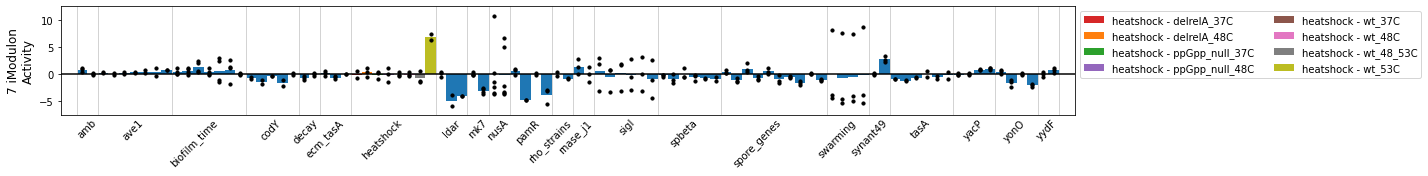

In [22]:
plot_activities(ica_data,7,highlight=['heatshock'])

In [23]:
DF_enrichments[DF_enrichments.imodulon=='7'].sort_values('f1score',ascending=False)

,imodulon,annotation,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,source,kegg_id,pathway_name,module_name,value


In [24]:
# Update the ica_data object
ica_data.rename_imodulons({7:'YvaF'})
ica_data.imodulon_table.loc['YvaF','category'] = 'functional'

### iModulon 9: Unknown
Another technical artifact from the MK7 project

In [25]:
ica_data.view_imodulon(9)

,gene_weight,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,uniprot,operon,regulator
BSU_00240,-0.041348,csfB,AL009126.3,BSU00240,35531,35725,+,forespore-specific anti-sigma factor,Function unknown,P37534,Op17,"SigK,SigF"
BSU_01620,0.045969,feuB,AL009126.3,BSU01620,181347,182351,-,ferri-bacillibactin permease,Inorganic ion transport and metabolism,P40410,Op121,"SigA,Btr,Fur"
BSU_01790,-0.099195,ybbU,AL009126.3,BSU01790,202126,202266,+,hypothetical protein,No COG annotation,A0A2K4Z9G0,Op134,NaN
BSU_02180,-0.086825,ybfEc,AL009126.3,NaN,238164,238448,-,conserved protein of unknown function (C-termi...,No COG annotation,NaN,Op163,NaN
BSU_02785,-0.033619,BSU_02785,AL009126.3,BSU02785,300525,300656,-,hypothetical protein,No COG annotation,A0A2K4Z9F5,Op212,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
BSU_40529,0.046294,yyzH,AL009126.3,BSU40529,4166815,4166964,-,hypothetical protein,No COG annotation,C0H3U2,Op3106,SigB
BSU_40578,0.105474,yyzK,AL009126.3,NaN,4172259,4172405,-,hypothetical protein,No COG annotation,NaN,Op3115,NaN
BSU_40579,0.121683,yyzL,AL009126.3,NaN,4172387,4172536,-,hypothetical protein,No COG annotation,NaN,Op3116,NaN
BSU_40640,-0.039631,yybH,AL009126.3,BSU40640,4177756,4178145,-,conserved hypothetical protein,Function unknown,P37496,Op3118,NaN


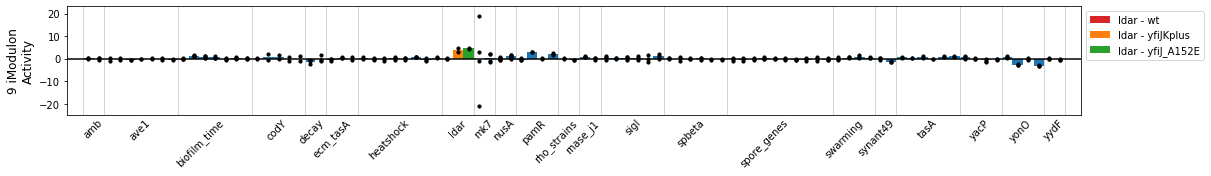

In [26]:
plot_activities(ica_data,9,highlight=['ldar'])

In [27]:
DF_enrichments[DF_enrichments.imodulon=='9'].sort_values('f1score',ascending=False)

,imodulon,annotation,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,source,kegg_id,pathway_name,module_name,value
36,9,NaN,1.455111e-07,0.000042,0.070588,0.255319,0.110599,12.0,47.0,170.0,NaN,NaN,NaN,NaN,pseudogenes
37,9,NaN,1.078468e-04,0.013181,0.152941,0.085526,0.109705,26.0,304.0,170.0,NaN,NaN,NaN,NaN,Prophages and mobile genetic elements
38,9,NaN,1.382586e-04,0.013181,0.147059,0.085911,0.108460,25.0,291.0,170.0,NaN,NaN,NaN,NaN,prophages
39,9,NaN,5.876380e-04,0.042016,0.305882,0.059908,0.100193,52.0,868.0,170.0,NaN,NaN,NaN,NaN,proteins of unknown function


In [28]:
# Update the ica_data object
ica_data.rename_imodulons({9:'uncharacterized-3'})

### iModulon 51: Unknown

In [29]:
ica_data.view_imodulon(51)

,gene_weight,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,uniprot,operon,regulator
BSU_04530,0.076764,fbpB,AL009126.3,BSU04530,506322,506501,-,regulator of iron homeostasis,Function unknown,P96609,Op338,Fur
BSU_04990,0.079265,yddJ,AL009126.3,BSU04990,545595,545975,+,ICEBs1 mobile element: putative lipoprotein of...,Function unknown,P96647,Op377,"ImmR,AbrB"
BSU_25565,0.071803,BSU_25565,AL009126.3,BSU25565,2637179,2637328,-,hypothetical protein,No COG annotation,A0A2K4Z9K3,Op2018,NaN
BSU_27600,0.155245,rsh,AL009126.3,BSU27600,2820529,2822733,-,GTP pyrophosphokinase (RelA/SpoT),Transcription,O54408,Op2206,NaN


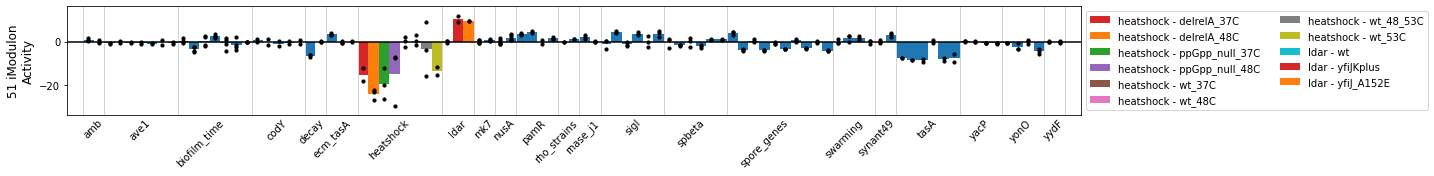

In [30]:
plot_activities(ica_data,51,highlight=['heatshock','ldar'])

In [31]:
DF_enrichments[DF_enrichments.imodulon=='51'].sort_values('f1score',ascending=False)

,imodulon,annotation,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,source,kegg_id,pathway_name,module_name,value


In [32]:
# Update the ica_data object
ica_data.rename_imodulons({51:'uncharacterized-4'})

### iModulon 52: ykzB-related
This iModulon is only down-regulated during sporulation when ykzB is deleted.

In [33]:
ica_data.view_imodulon(52)

,gene_weight,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,uniprot,operon,regulator
BSU_18130,0.095418,eglS,AL009126.3,BSU18130,1940625,1942124,+,endo-1%2C4-beta-glucanase,Carbohydrate transport and metabolism,P10475,Op1382,SigA
BSU_18140,0.156711,ynfE,AL009126.3,BSU18140,1942192,1942455,+,conserved hypothetical protein,No COG annotation,Q45069,Op1383,NaN
BSU_18150,0.083893,xynC,AL009126.3,BSU18150,1942714,1943982,-,secreted endo-xylanase,Cell wall/membrane/envelope biogenesis,Q45070,Op1384,AbrB
BSU_18160,0.082117,xynD,AL009126.3,BSU18160,1944113,1945654,-,arabinoxylan arabinofuranohydrolase,Carbohydrate transport and metabolism,Q45071,Op1385,AbrB
BSU_18190,0.083229,yngC,AL009126.3,BSU18190,1947668,1948264,+,putative integral inner membrane protein%2C ph...,Function unknown,O31823,Op1388,"SigM,YclJ"
BSU_18200,0.145381,nrnB,AL009126.3,BSU18200,1948313,1949512,-,oligoribonuclease (nanoRNase),Function unknown,O31824,Op1389,NaN
BSU_18210,0.208872,ldeE,AL009126.3,BSU18210,1949682,1951217,-,methylcrotonoyl-CoA carboxylase subunit (leuci...,Lipid transport and metabolism,O31825,Op1390,SigE
BSU_18220,0.227312,ldeF,AL009126.3,BSU18220,1951228,1952010,-,methylglutaconyl-CoA hydratase (leucine degrad...,Lipid transport and metabolism,O34893,Op1390,SigE
BSU_18230,0.223275,ldeG,AL009126.3,BSU18230,1952031,1952930,-,hydroxymethylglutaryl-CoA lyase (leucine degra...,Amino acid transport and metabolism,O34873,Op1390,SigE
BSU_18239,0.237199,lgeHB,AL009126.3,BSU18239,1952945,1953166,-,methylcrotonyl-CoA carboxylase%3B biotinylated...,Lipid transport and metabolism,C0H419,Op1390,SigE


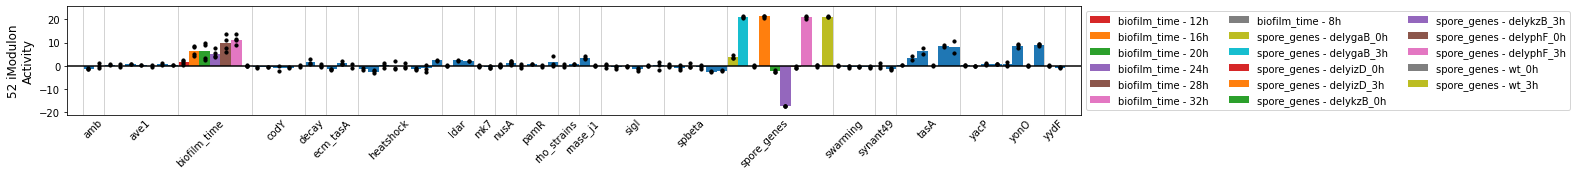

In [34]:
plot_activities(ica_data,52,highlight=['biofilm_time','spore_genes'])

In [35]:
DF_enrichments[DF_enrichments.imodulon=='52'].sort_values('f1score',ascending=False)

,imodulon,annotation,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,source,kegg_id,pathway_name,module_name,value
273,52,NaN,3.396203e-13,9.713141e-11,0.4375,0.318182,0.368421,7.0,22.0,16.0,NaN,NaN,NaN,NaN,utilization of branched-chain amino acids
73,52,NaN,4.550649e-04,9.310647e-02,0.1250,0.222222,0.160000,2.0,9.0,16.0,NaN,M00082,NaN,"Fatty acid biosynthesis, initiation",NaN
274,52,NaN,3.585559e-09,5.127349e-07,0.4375,0.093333,0.153846,7.0,75.0,16.0,NaN,NaN,NaN,NaN,utilization of amino acids
74,52,NaN,6.922414e-04,9.310647e-02,0.1250,0.181818,0.148148,2.0,11.0,16.0,NaN,M00376,NaN,3-Hydroxypropionate bi-cycle,NaN
279,52,NaN,9.095451e-05,3.716141e-03,0.1875,0.120000,0.146341,3.0,25.0,16.0,NaN,NaN,NaN,NaN,utilization of other polymeric carbohydrates
95,52,NaN,1.587503e-04,3.571881e-02,0.1875,0.100000,0.130435,3.0,30.0,16.0,NaN,map01212,Fatty acid metabolism,NaN,NaN
277,52,NaN,1.607265e-05,9.193555e-04,0.4375,0.027559,0.051852,7.0,279.0,16.0,NaN,NaN,NaN,NaN,amino acid/ nitrogen metabolism
278,52,NaN,4.191706e-05,1.998047e-03,0.4375,0.023810,0.045161,7.0,294.0,16.0,NaN,NaN,NaN,NaN,sporulation proteins/ other
275,52,NaN,9.165722e-07,8.737989e-05,0.6250,0.021277,0.041152,10.0,470.0,16.0,NaN,NaN,NaN,NaN,sporulation proteins
276,52,NaN,4.970116e-06,3.553633e-04,0.6250,0.017762,0.034542,10.0,568.0,16.0,NaN,NaN,NaN,NaN,sporulation


In [36]:
# Update the ica_data object
ica_data.rename_imodulons({52:'ykzB-related'})
ica_data.imodulon_table.loc['ykzB-related','category'] = 'functional'

### iModulon 61: early biofilm

In [37]:
ica_data.view_imodulon(61)

,gene_weight,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,uniprot,operon,regulator
BSU_03359,0.070463,yczL,AL009126.3,BSU03359,365850,366035,+,hypothetical protein,No COG annotation,C0H3U7,Op251,"SigA,Zur"
BSU_07560,0.060866,pelA,AL009126.3,BSU07560,827993,829255,+,pectate lyase,Carbohydrate transport and metabolism,P39116,Op602,"ComA,TnrA,CcpA"
BSU_08230,0.084936,catD,AL009126.3,BSU08230,897588,897992,+,catechol-2%2C3-dioxygenase membrane subunit,Function unknown,P54720,Op640,"SigA,CatR,YodB,Fur"
BSU_08240,0.082969,catE,AL009126.3,BSU08240,898010,898867,+,catechol-2%2C3-dioxygenase subunit,Function unknown,P54721,Op640,"SigA,CatR,YodB,Fur"
BSU_10300,0.060752,aprE,AL009126.3,BSU10300,1104423,1105568,-,serine alkaline protease (Ca(2+)-dependent sub...,"Post-translational modification, protein turno...",P04189,Op807,"SigA,SinR,CodY,DegU,AbrB,ScoC"
BSU_11040,0.109451,yitM,AL009126.3,BSU11040,1182448,1183032,-,conserved hypothetical protein,No COG annotation,O06748,Op864,NaN
BSU_11055,0.074836,yitO,AL009126.3,BSU11055,1183029,1183958,-,putative integral inner membrane protein with ...,No COG annotation,O06750,Op864,NaN
BSU_11070,0.066387,yitP,AL009126.3,BSU11070,1183943,1184479,-,conserved hypothetical protein,Function unknown,O06751,Op864,NaN
BSU_12200,0.081363,yjiA,AL009126.3,BSU12200,1290675,1290953,-,hypothetical protein,No COG annotation,O34679,Op955,NaN
BSU_13190,0.081301,ispA,AL009126.3,BSU13190,1386024,1386983,-,intracellular serine protease,"Post-translational modification, protein turno...",P11018,Op1028,"SigA,CodY"


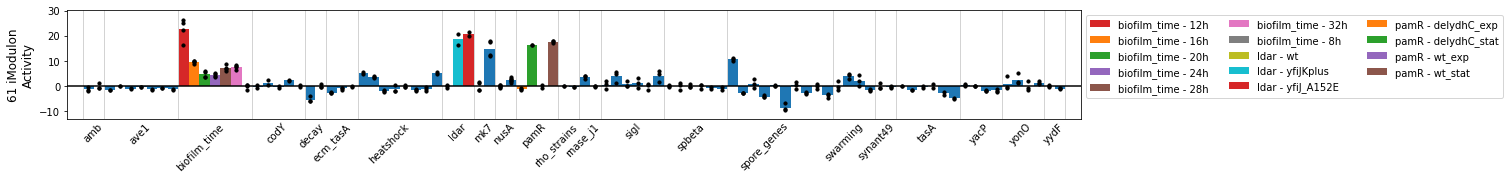

In [38]:
plot_activities(ica_data,61,highlight=['biofilm_time','ldar','pamR'])

In [39]:
DF_enrichments[DF_enrichments.imodulon=='61'].sort_values('f1score',ascending=False)

,imodulon,annotation,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,source,kegg_id,pathway_name,module_name,value
341,61,NaN,1.539137e-10,4.401931e-08,0.142857,0.833333,0.243902,5.0,6.0,35.0,NaN,NaN,NaN,NaN,capsule biosynthesis and degradation
342,61,NaN,3.134567e-06,4.482431e-04,0.171429,0.113208,0.136364,6.0,105.0,35.0,NaN,NaN,NaN,NaN,biosynthesis of antibacterial compounds
343,61,NaN,3.508377e-05,3.344653e-03,0.171429,0.075000,0.104348,6.0,80.0,35.0,NaN,NaN,NaN,NaN,miscellaneous metabolic pathways


In [40]:
# Update ICA data object
ica_data.rename_imodulons({61:'early-biofilm'})
ica_data.imodulon_table.loc['early-biofilm','category'] = 'functional'

### iModulon 68: Unknown

In [41]:
ica_data.view_imodulon(68)

,gene_weight,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,uniprot,operon,regulator
BSU_00440,0.091876,veg,AL009126.3,BSU00440,52763,53023,+,conserved hypothetical protein,Function unknown,P37466,Op35,SigA
BSU_00450,0.056840,sspF,AL009126.3,BSU00450,53183,53368,+,small acid-soluble spore protein (alpha/beta-t...,Function unknown,P37549,Op36,SigG
BSU_01889,0.053660,ybzH,AL009126.3,BSU01889,211429,211731,+,putative transcriptional regulator (ArsR famil...,Transcription,C0H3S9,Op142,NaN
BSU_02785,0.048965,BSU_02785,AL009126.3,BSU02785,300525,300656,-,hypothetical protein,No COG annotation,A0A2K4Z9F5,Op212,NaN
BSU_03780,0.111154,phrC,AL009126.3,BSU03780,429963,430085,+,secreted regulator of the activity of phosphat...,No COG annotation,P94416,Op284,"SigA,ComA,CodY,SigH,CcpA"
BSU_05120,0.060560,cspC,AL009126.3,BSU05120,559264,559464,+,cold-shock protein,Transcription,P39158,Op391,NaN
BSU_06269,0.078490,ydzJ,AL009126.3,BSU06269,680907,681065,-,hypothetical protein,No COG annotation,O24817,Op503,NaN
BSU_09630,0.116020,yhdX,AL009126.3,BSU09630,1038653,1038760,+,conserved hypothetical protein,No COG annotation,O07593,Op745,NaN
BSU_09700,0.188637,bmrB,AL009126.3,BSU09700,1045037,1045198,+,regulator leader peptide,No COG annotation,O07551,Op752,"AbrB,BmrB"
BSU_10230,0.058568,yhfH,AL009126.3,BSU10230,1098120,1098260,-,conserved protein of unknown function,Function unknown,O07606,Op800,YlxR


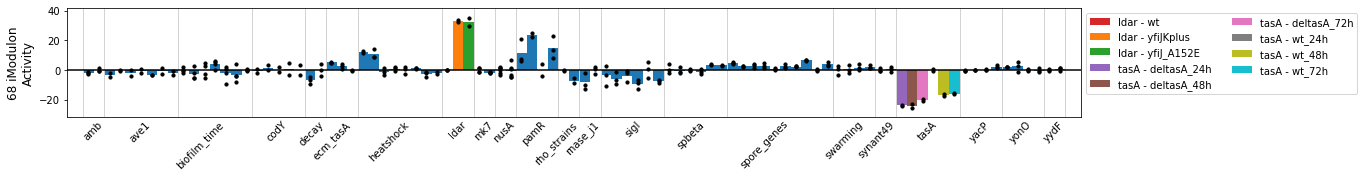

In [42]:
plot_activities(ica_data,68,highlight=['ldar','tasA'])

In [43]:
DF_enrichments[DF_enrichments.imodulon=='68'].sort_values('f1score',ascending=False)

,imodulon,annotation,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,source,kegg_id,pathway_name,module_name,value
368,68,NaN,0.000035,0.010114,0.074074,0.25,0.114286,4.0,16.0,54.0,NaN,NaN,NaN,NaN,control of response regulators/ other
369,68,NaN,0.000208,0.029685,0.055556,0.30,0.093750,3.0,10.0,54.0,NaN,NaN,NaN,NaN,short peptides


In [44]:
# Update the ica_data object
ica_data.rename_imodulons({68:'uncharacterized-5'})

### iModulon 69: cssRS

In [45]:
ica_data.view_imodulon(69)

,gene_weight,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,uniprot,operon,regulator
BSU_07770,0.089101,yfkS,AL009126.3,BSU07770,847282,847482,-,putative spore germination D protein,No COG annotation,O35036,Op616,"SigB,SigG"
BSU_07780,0.113342,yfkR,AL009126.3,BSU07780,847498,848652,-,putative spore germination protein,Function unknown,O35028,Op616,"SigB,SigG"
BSU_18978,0.089788,bsrE,AL009126.3,BSU18978,2069883,2069975,+,type I toxin (BsrE/AsrE),No COG annotation,A0A2K4Z9J5,Op1467,NaN
BSU_33010,0.184001,cssR,AL009126.3,BSU33010,3385724,3386401,+,folding stress-sensitive two-component respons...,Signal transduction mechanisms,O32192,Op2595,"SigA,CssR"
BSU_33020,0.230461,cssS,AL009126.3,BSU33020,3386398,3387753,+,folding stress-sensitive two-component sensor ...,Signal transduction mechanisms,O32193,Op2595,"SigA,CssR"
BSU_35810,0.098531,gerBB,AL009126.3,BSU35810,3690269,3691375,+,component of germinant receptor B,Amino acid transport and metabolism,P39570,Op2788,SigG
BSU_35820,0.099053,gerBC,AL009126.3,BSU35820,3691372,3692496,+,lipoprotein component of the germination recep...,Function unknown,P39571,Op2788,SigG


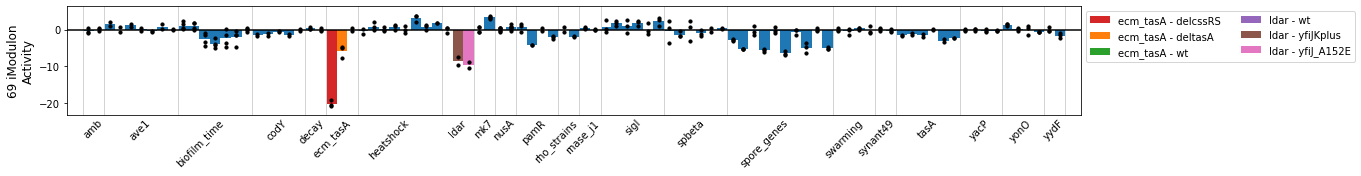

In [46]:
plot_activities(ica_data,69,highlight=['ecm_tasA','ldar'])

In [47]:
DF_enrichments[DF_enrichments.imodulon=='69'].sort_values('f1score',ascending=False)

,imodulon,annotation,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,source,kegg_id,pathway_name,module_name,value
93,69,NaN,0.000002,0.000604,0.285714,1.0,0.444444,2.0,2.0,7.0,NaN,M00448,NaN,NaN,NaN


In [48]:
# Update the ICA data object

ica_data.rename_imodulons({69:'putative-cssRS'})
ica_data.imodulon_table.loc['putative-cssRS','category'] = 'functional'

### iModulon 70: Unknown

In [49]:
ica_data.view_imodulon(70)

,gene_weight,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,uniprot,operon,regulator
BSU_01000,-0.062140,secE,AL009126.3,BSU01000,117532,117711,+,preprotein translocase subunit,"Intracellular trafficking, secretion, and vesi...",Q06799,Op62,"SigA,AbrB"
BSU_02080,-0.053151,ybxH,AL009126.3,BSU02080,228331,228522,+,conserved protein of unknown function,Function unknown,P54426,Op154,"SpoVT,SigG"
BSU_02585,0.065121,BSU_02585,AL009126.3,BSU02585,281675,281809,-,hypothetical protein,No COG annotation,A0A2K4Z9H7,Op192,NaN
BSU_03788,-0.058862,yczM,AL009126.3,BSU03788,430185,430274,-,putative type I toxin,No COG annotation,C0H3V0,Op285,NaN
BSU_03789,0.063835,yczN,AL009126.3,BSU03789,430356,430469,-,putative spore and germination protein,No COG annotation,C0H3V1,Op286,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
BSU_39139,0.081856,yxzJ,AL009126.3,BSU39139,4019005,4019136,-,conserved protein of unknown function,No COG annotation,C0H3T5,Op3025,NaN
BSU_40120,-0.061538,ptsJ,AL009126.3,BSU40120,4122619,4122849,-,glucose phosphotransferase system enzyme IIA c...,Carbohydrate transport and metabolism,O32292,Op3077,NaN
BSU_40160,0.059322,liaK,AL009126.3,BSU40160,4125742,4126500,-,membrane metalloprotease acting on modified fa...,"Post-translational modification, protein turno...",Q45594,Op3080,"Rok,SigA,AbrB"
BSU_40310,-0.066793,phrG,AL009126.3,BSU40310,4141358,4141474,+,secreted regulator of the activity of phosphat...,No COG annotation,O32295,Op3092,"SigA,SinR,RghR,SigH,CcpA"


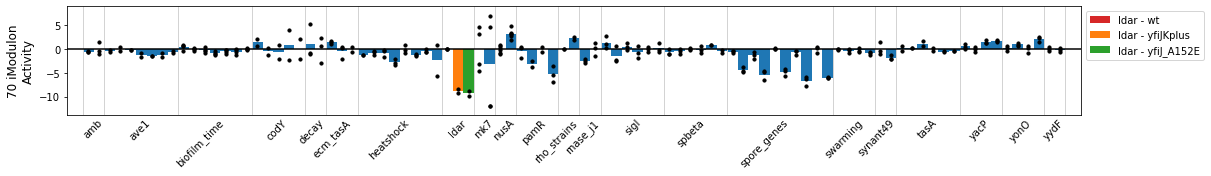

In [50]:
plot_activities(ica_data,70,highlight=['ldar'])

In [51]:
# Update the ica_data object
ica_data.rename_imodulons({70:'uncharacterized-6'})

### iModulon 71: Putative yxi-operon

In [52]:
ica_data.view_imodulon(71)

,gene_weight,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,uniprot,operon,regulator
BSU_39120,0.107038,yxiM,AL009126.3,BSU39120,4017508,4018656,-,esterase (lipoprotein),Amino acid transport and metabolism,P42304,Op3023,NaN
BSU_39129,0.111279,yxzI,AL009126.3,NaN,4018786,4018974,-,hypothetical protein,No COG annotation,NaN,Op3024,NaN
BSU_39139,0.113504,yxzJ,AL009126.3,BSU39139,4019005,4019136,-,conserved protein of unknown function,No COG annotation,C0H3T5,Op3025,NaN
BSU_39140,0.116876,yxiK,AL009126.3,BSU39140,4019148,4019609,-,conserved protein of unknown function,No COG annotation,P42302,Op3026,NaN
BSU_39150,0.115552,yxiJ,AL009126.3,BSU39150,4019625,4019921,-,conserved protein of unknown function,Function unknown,P42320,Op3027,NaN
BSU_39160,0.127599,yxiI,AL009126.3,BSU39160,4019949,4020437,-,conserved protein of unknown function,Function unknown,P42301,Op3028,NaN
BSU_39170,0.133228,yxzG,AL009126.3,BSU39170,4020455,4020907,-,putative nucleic acid binding protein,No COG annotation,O32285,Op3029,NaN
BSU_39180,0.130903,yxiH,AL009126.3,BSU39180,4020977,4021306,-,conserved protein of unknown function,No COG annotation,P42300,Op3030,NaN
BSU_39190,0.141250,yxiG,AL009126.3,BSU39190,4021429,4021845,-,conserved hypothetical protein,No COG annotation,P42299,Op3031,NaN
BSU_39200,0.130152,yxzC,AL009126.3,BSU39200,4021896,4022264,-,putative nucleic acid binding protein,No COG annotation,O32286,Op3032,NaN


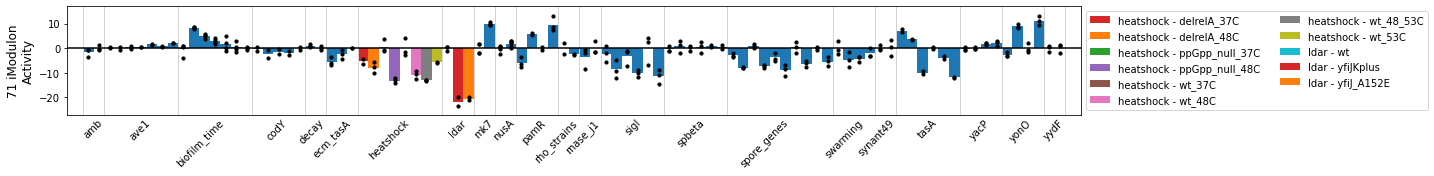

In [53]:
plot_activities(ica_data,71,highlight=['ldar','heatshock'])

In [54]:
# Update ICA data object
ica_data.rename_imodulons({71:'yxi-operon'})
ica_data.imodulon_table.loc['yxi-operon','category'] = 'functional'

## Double-check low-scoring iModulons

In [55]:
ica_data.imodulon_table[ica_data.imodulon_table['f1score']  < 0.25]

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs,single_gene,explained_variance,category
CsoR/Fnr,CsoR/Fnr,1.842216e-11,8.799896e-07,0.113636,0.400000,0.176991,10.0,25.0,88,2.0,NaN,0.018237,regulatory
RhgR,RhgR,4.739042e-13,1.611274e-11,0.062500,1.000000,0.117647,8.0,8.0,128,1.0,NaN,0.019527,regulatory
NusA,NusA,1.788207e-11,7.510469e-10,0.054264,1.000000,0.102941,7.0,7.0,129,1.0,NaN,0.011770,regulatory
CsoR,CsoR,1.163609e-10,8.145265e-10,0.127273,0.500000,0.202899,7.0,14.0,55,1.0,NaN,0.015380,regulatory
DegU,DegU,2.854706e-11,1.427353e-10,0.370370,0.119048,0.180180,10.0,84.0,27,1.0,NaN,0.005933,regulatory
Rok,Rok,6.692924e-17,1.673231e-15,0.156250,0.441176,0.230769,15.0,34.0,96,1.0,NaN,0.008361,regulatory
YonO-2,YonO,4.492705e-08,8.985409e-08,0.416667,0.121951,0.188679,5.0,41.0,12,1.0,NaN,0.000940,regulatory
AbrB,AbrB,6.614330e-22,8.598629e-21,0.869565,0.073801,0.136054,20.0,271.0,23,1.0,NaN,0.024879,regulatory
CcpA-2,CcpA,4.279881e-27,6.419821e-26,0.812500,0.099237,0.176871,26.0,262.0,32,1.0,NaN,0.008381,regulatory


In [56]:
def clear_row(imodulon):
    clear_columns = ['regulator','pvalue','qvalue','precision','recall','f1score','TP','regulon_size','n_regs']
    
    for col in clear_columns:
        ica_data.imodulon_table.loc[imodulon,col] = None

### CsoR/Fnr -> SPbeta-1

In [57]:
ica_data.imodulon_table.loc['CsoR/Fnr']

regulator                CsoR/Fnr
pvalue                1.84222e-11
qvalue                 8.7999e-07
precision                0.113636
recall                        0.4
f1score                  0.176991
TP                             10
regulon_size                   25
imodulon_size                  88
n_regs                          2
single_gene                   NaN
explained_variance      0.0182374
category               regulatory
Name: CsoR/Fnr, dtype: object

In [58]:
DF_enrichments[DF_enrichments.imodulon=='CsoR/Fnr'].sort_values('f1score',ascending=False)

,imodulon,annotation,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,source,kegg_id,pathway_name,module_name,value
30,CsoR/Fnr,NaN,6.770882e-80,1.936472e-77,0.772727,0.361702,0.492754,68.0,188.0,88.0,NaN,NaN,NaN,NaN,SP-beta prophage
31,CsoR/Fnr,NaN,7.175086e-65,1.026037e-62,0.772727,0.233677,0.358839,68.0,291.0,88.0,NaN,NaN,NaN,NaN,prophages
32,CsoR/Fnr,NaN,1.953503e-63,1.862339e-61,0.772727,0.223684,0.346939,68.0,304.0,88.0,NaN,NaN,NaN,NaN,Prophages and mobile genetic elements
33,CsoR/Fnr,NaN,3.678034e-07,2.629795e-05,0.056818,0.555556,0.103093,5.0,9.0,88.0,NaN,NaN,NaN,NaN,anaerobic respiration
35,CsoR/Fnr,NaN,8.372872e-05,3.991069e-03,0.068182,0.162162,0.096000,6.0,37.0,88.0,NaN,NaN,NaN,NaN,respiration
34,CsoR/Fnr,NaN,1.866140e-05,1.067432e-03,0.045455,0.444444,0.082474,4.0,9.0,88.0,NaN,NaN,NaN,NaN,overflow metabolism
10,CsoR/Fnr,NaN,3.111113e-04,7.000005e-02,0.045455,0.235294,0.076190,4.0,17.0,88.0,NaN,map00910,Nitrogen metabolism,NaN,NaN
10,CsoR/Fnr,NaN,8.144105e-06,2.190764e-03,0.034091,1.000000,0.065934,3.0,3.0,88.0,NaN,M00529,NaN,"Denitrification, nitrate => nitrogen",NaN
11,CsoR/Fnr,NaN,1.557860e-04,2.095322e-02,0.034091,0.500000,0.063830,3.0,6.0,88.0,NaN,M00530,NaN,"Dissimilatory nitrate reduction, nitrate => am...",NaN
12,CsoR/Fnr,NaN,4.093833e-04,3.670804e-02,0.022727,1.000000,0.044444,2.0,2.0,88.0,NaN,M00804,NaN,"Complete nitrification, comammox, ammonia => n...",NaN


In [59]:
# Update the ICA data object

ica_data.rename_imodulons({'CsoR/Fnr':'SPbeta-1'})
ica_data.imodulon_table.loc['SPbeta-1','category'] = 'functional'
clear_row('SPbeta-1')

### RhgR -> Carbon metabolism/skin element

In [60]:
ica_data.imodulon_table.loc['RhgR']

regulator                    RhgR
pvalue                4.73904e-13
qvalue                1.61127e-11
precision                  0.0625
recall                          1
f1score                  0.117647
TP                              8
regulon_size                    8
imodulon_size                 128
n_regs                          1
single_gene                   NaN
explained_variance      0.0195274
category               regulatory
Name: RhgR, dtype: object

In [61]:
DF_enrichments[DF_enrichments.imodulon=='RhgR'].sort_values('f1score',ascending=False)

,imodulon,annotation,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,source,kegg_id,pathway_name,module_name,value
83,RhgR,NaN,4.916032e-15,7.029925e-13,0.257812,0.143478,0.184358,33.0,239.0,128.0,NaN,NaN,NaN,NaN,utilization of specific carbon sources
82,RhgR,NaN,3.414975e-18,9.766827e-16,0.093750,0.923077,0.170213,12.0,13.0,128.0,NaN,NaN,NaN,NaN,utilization of pectin
84,RhgR,NaN,2.442151e-12,2.328184e-10,0.257812,0.116197,0.160194,33.0,299.0,128.0,NaN,NaN,NaN,NaN,carbon metabolism
85,RhgR,NaN,1.883701e-10,1.346846e-08,0.117188,0.238095,0.157068,15.0,63.0,128.0,NaN,NaN,NaN,NaN,Skin element
90,RhgR,NaN,2.879252e-04,9.149623e-03,0.156250,0.068729,0.095465,20.0,291.0,128.0,NaN,NaN,NaN,NaN,prophages
91,RhgR,NaN,5.123535e-04,1.465331e-02,0.156250,0.065789,0.092593,20.0,304.0,128.0,NaN,NaN,NaN,NaN,Prophages and mobile genetic elements
92,RhgR,NaN,1.857884e-03,4.830500e-02,0.187500,0.054920,0.084956,24.0,437.0,128.0,NaN,NaN,NaN,NaN,transporters
93,RhgR,NaN,3.471510e-03,8.273765e-02,0.109375,0.066351,0.082596,14.0,211.0,128.0,NaN,NaN,NaN,NaN,ABC transporters
24,RhgR,NaN,2.234027e-05,3.004766e-03,0.039062,0.384615,0.070922,5.0,13.0,128.0,NaN,M00429,NaN,NaN,NaN
88,RhgR,NaN,7.057531e-05,2.883505e-03,0.039062,0.312500,0.069444,5.0,16.0,128.0,NaN,NaN,NaN,NaN,utilization of hexuronate


In [62]:
# Update the ICA data object

ica_data.rename_imodulons({'RhgR':'carbon metabolism/skin element'})
ica_data.imodulon_table.loc['carbon metabolism/skin element','category'] = 'functional'
clear_row('carbon metabolism/skin element')

## NusA -> ComK/LevR/NusA

In [63]:
ica_data.imodulon_table.loc['NusA']

regulator                    NusA
pvalue                1.78821e-11
qvalue                7.51047e-10
precision               0.0542636
recall                          1
f1score                  0.102941
TP                              7
regulon_size                    7
imodulon_size                 129
n_regs                          1
single_gene                   NaN
explained_variance      0.0117704
category               regulatory
Name: NusA, dtype: object

In [64]:
DF_enrichments[DF_enrichments.imodulon=='NusA'].sort_values('f1score',ascending=False)

,imodulon,annotation,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,source,kegg_id,pathway_name,module_name,value
206,NusA,NaN,7.520894e-07,1.075488e-04,0.147287,0.107955,0.124590,19.0,187.0,129.0,NaN,NaN,NaN,NaN,genetics
57,NusA,NaN,5.731914e-10,1.541885e-07,0.062016,0.615385,0.112676,8.0,13.0,129.0,NaN,M00429,NaN,NaN,NaN
207,NusA,NaN,2.144949e-06,2.044851e-04,0.077519,0.192308,0.110497,10.0,104.0,129.0,NaN,NaN,NaN,NaN,genetic competence
76,NusA,NaN,2.640817e-08,5.941839e-06,0.054264,0.538462,0.098592,7.0,13.0,129.0,NaN,map00290,"Valine, leucine and isoleucine biosynthesis",NaN,NaN
205,NusA,NaN,2.708177e-07,7.745386e-05,0.054264,0.411765,0.095890,7.0,17.0,129.0,NaN,NaN,NaN,NaN,biosynthesis/ acquisition of branched-chain am...
209,NusA,NaN,5.143547e-04,2.788112e-02,0.209302,0.057447,0.090150,27.0,470.0,129.0,NaN,NaN,NaN,NaN,sporulation proteins
78,NusA,NaN,1.253048e-05,9.397862e-04,0.054264,0.250000,0.089172,7.0,28.0,129.0,NaN,map01210,2-Oxocarboxylic acid metabolism,NaN,NaN
212,NusA,NaN,2.183264e-03,7.805167e-02,0.317829,0.045354,0.079380,41.0,1131.0,129.0,NaN,NaN,NaN,NaN,Information processing
213,NusA,NaN,2.457999e-03,7.810976e-02,0.054264,0.111111,0.072917,7.0,63.0,129.0,NaN,NaN,NaN,NaN,Skin element
210,NusA,NaN,5.849187e-04,2.788112e-02,0.046512,0.166667,0.072727,6.0,36.0,129.0,NaN,NaN,NaN,NaN,tRNA modification and maturation


In [65]:
ica_data.compute_trn_enrichment('NusA', max_regs=3,force=True,save=True)

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,NusA,ComK/LevR/NusA,2.191960e-21,7.674319e-15,0.193798,0.352113,0.250000,25.0,71.0,129.0,3.0
1,NusA,LevR/OhrR/NusA,8.056984e-21,1.410424e-14,0.100775,1.000000,0.183099,13.0,13.0,129.0,3.0
2,NusA,LevR/YfmP/NusA,1.099801e-19,6.417561e-14,0.100775,0.928571,0.181818,13.0,14.0,129.0,3.0
3,NusA,ComK/SigL/NusA,7.419812e-20,6.417561e-14,0.201550,0.292135,0.238532,26.0,89.0,129.0,3.0
4,NusA,ComK/NusA/T-box,6.486468e-20,6.417561e-14,0.217054,0.261682,0.237288,28.0,107.0,129.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
460,NusA,ComK/SigG/MalR,1.287429e-09,9.758854e-06,0.193798,0.119048,0.147493,25.0,210.0,129.0,3.0
461,NusA,ComK/SigG/SacY,1.287429e-09,9.758854e-06,0.193798,0.119048,0.147493,25.0,210.0,129.0,3.0
462,NusA,SigL/MhqR/T-box,1.290543e-09,9.758854e-06,0.116279,0.211268,0.150000,15.0,71.0,129.0,3.0
463,NusA,NusA/MhqR,1.304144e-09,9.819285e-06,0.062016,0.571429,0.111888,8.0,14.0,129.0,2.0


In [66]:
# Update the ICA data object

ica_data.rename_imodulons({'NusA':'ComK/LevR/NusA'})

## CsoR -> SPbeta-2

In [67]:
ica_data.imodulon_table.loc['CsoR']

regulator                    CsoR
pvalue                1.16361e-10
qvalue                8.14527e-10
precision                0.127273
recall                        0.5
f1score                  0.202899
TP                              7
regulon_size                   14
imodulon_size                  55
n_regs                          1
single_gene                   NaN
explained_variance      0.0153802
category               regulatory
Name: CsoR, dtype: object

In [68]:
DF_enrichments[DF_enrichments.imodulon=='CsoR'].sort_values('f1score',ascending=False)

,imodulon,annotation,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,source,kegg_id,pathway_name,module_name,value
214,CsoR,NaN,4.560304e-76,1.304247e-73,0.981818,0.287234,0.444444,54.0,188.0,55.0,NaN,NaN,NaN,NaN,SP-beta prophage
215,CsoR,NaN,1.937387e-64,2.770463e-62,0.981818,0.185567,0.312139,54.0,291.0,55.0,NaN,NaN,NaN,NaN,prophages
216,CsoR,NaN,2.598987e-63,2.477701e-61,0.981818,0.177632,0.300836,54.0,304.0,55.0,NaN,NaN,NaN,NaN,Prophages and mobile genetic elements
64,CsoR,NaN,2.192982e-04,5.899121e-02,0.054545,0.300000,0.092308,3.0,10.0,55.0,NaN,M00053,NaN,"Pyrimidine deoxyribonuleotide biosynthesis, CD...",NaN
217,CsoR,NaN,9.373689e-04,6.702187e-02,0.036364,0.500000,0.067797,2.0,4.0,55.0,NaN,NaN,NaN,NaN,DNA replication/ based on similarity


In [69]:
# Update the ICA data object

ica_data.rename_imodulons({'CsoR':'SPbeta-2'})
ica_data.imodulon_table.loc['SPbeta-2','category'] = 'functional'
clear_row('SPbeta-2')

## Xpf

In [70]:
ica_data.compute_trn_enrichment('Xpf',max_regs=2,save=True)

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,Xpf,Xre/Xpf,5.255146e-69,2.509332e-64,0.611111,1.000000,0.758621,33.0,33.0,54.0,2.0
1,Xpf,Xpf,1.548917e-55,3.698039e-51,0.500000,1.000000,0.666667,27.0,27.0,54.0,1.0
2,Xpf,Xpf/YclJ,2.809484e-50,4.471762e-46,0.518519,0.777778,0.622222,28.0,36.0,54.0,2.0
3,Xpf,Xpf/FadR,4.263676e-49,5.089764e-45,0.537037,0.674419,0.597938,29.0,43.0,54.0,2.0
4,Xpf,Xpf/LexA,1.367897e-41,1.306342e-37,0.574074,0.369048,0.449275,31.0,84.0,54.0,2.0
5,Xpf,SigM/Xpf,9.957493e-31,7.924505e-27,0.518519,0.233333,0.321839,28.0,120.0,54.0,2.0
6,Xpf,Xpf/AbrB,1.074619e-21,7.330439e-18,0.555556,0.100671,0.170455,30.0,298.0,54.0,2.0
7,Xpf,Xre,2.851014e-12,1.701699e-08,0.111111,1.000000,0.200000,6.0,6.0,54.0,1.0
8,Xpf,Xre/FadR,9.651932e-11,5.120886e-07,0.148148,0.363636,0.210526,8.0,22.0,54.0,2.0
9,Xpf,Xre/YclJ,1.888649e-10,9.018299e-07,0.129630,0.466667,0.202899,7.0,15.0,54.0,2.0


In [71]:
ica_data.rename_imodulons({'Xpf':'Xre/Xpf'})

## Adjust some thresholds

In [72]:
ica_data.change_threshold('Thi-box',.1)
ica_data.change_threshold('LnrK',.15)
ica_data.change_threshold('KipR',0.12)

# Recalculate enrichments
ica_data.compute_trn_enrichment(['Thi-box','LnrK','KipR'], save=True)

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,Thi-box,Thi-box,1.033185e-33,1.033185e-33,1.0,0.857143,0.923077,12.0,14.0,12.0,1.0
1,LnrK,LnrK,0.000000e+00,0.000000e+00,1.0,1.000000,1.000000,3.0,3.0,3.0,1.0
2,KipR,KipR,0.000000e+00,0.000000e+00,1.0,1.000000,1.000000,7.0,7.0,7.0,1.0
3,KipR,TnrA,8.103543e-13,1.620709e-12,1.0,0.083333,0.153846,7.0,84.0,7.0,1.0


## Add biological functions
This is only relevant for 'biological' and 'regulatory iModulons

In [73]:
subti_annot = pd.read_csv(path.join('..','data','external','subtiwiki_categories.csv'))
subti_annot.rename({'BSU_number':'gene_id'},axis=1,inplace=True)
subti_annot = subti_annot[subti_annot.gene_id.isin(ica_data.gene_names)]

In [74]:
subti_enrich = ica_data.compute_annotation_enrichment(subti_annot,'FuncName2')
functions = subti_enrich.sort_values('qvalue').drop_duplicates('imodulon').set_index('imodulon')['FuncName2']
functions = functions[ica_data.imodulon_table.category.isin(['regulatory','functional'])]
functions.head()

imodulon
SPbeta-1      prophages
SPbeta-2      prophages
SigK        sporulation
SigE        sporulation
Fur         homeostasis
Name: FuncName2, dtype: object

In [75]:
ica_data.imodulon_table['function'] = functions

### Manually curate functions

In [76]:
ica_data.imodulon_table.function.value_counts()

carbon metabolism                                    8
amino acid/ nitrogen metabolism                      6
coping with stress                                   6
prophages                                            5
nucleotide metabolism                                3
sporulation                                          3
exponential and early post-exponential lifestyles    3
homeostasis                                          3
electron transport and ATP synthesis                 3
transporters                                         2
additional metabolic pathways                        2
proteins of unknown function                         2
lipid metabolism                                     1
ncRNA                                                1
short peptides                                       1
essential genes                                      1
mobile genetic elements/ based on similarity         1
cell envelope and cell division                      1
mobile gen

In [77]:
rename = {'carbon metabolism':'Carbon Metabolism',
          'coping with stress':'Stress Response',
          'amino acid/ nitrogen metabolism':'AA/Nucleotide Metabolism',
          'prophages':'Prophages',
          'sporulation':'Lifestyles',
          'exponential and early post-exponential lifestyles':'Lifestyles',
          'electron transport and ATP synthesis': 'Misc. Metabolism',
          'homeostasis':'Homeostasis',
          'nucleotide metabolism':'AA/Nucleotide Metabolism',
          'proteins of unknown function':'Other',
          'additional metabolic pathways':'Misc. Metabolism',
          'short peptides':'Cellular Processes',
          'essential genes':'Cellular Processes',
          'transporters':'Misc. Metabolism',
          'mobile genetic elements': 'Cellular Processes',
          'ncRNA':'Cellular Processes',
          'mobile genetic elements/ based on similarity':'Cellular Processes',
          'lipid metabolism':'Misc. Metabolism',
          'cell envelope and cell division': 'Cellular Processes',
          'genetics':'Cellular Processes'}

In [78]:
ica_data.imodulon_table.function = ica_data.imodulon_table.function.replace(rename)

In [79]:
ica_data.imodulon_table.loc['ybc-operon','function'] = 'Prophages'
ica_data.imodulon_table.loc['SigI','function'] = 'Stress Response'
ica_data.imodulon_table.loc['LnrK','function'] = 'Cellular Processes'
ica_data.imodulon_table.loc['early-biofilm','function'] = 'Lifestyles'
ica_data.imodulon_table.loc['KipR','function'] = 'Misc. Metabolism'
ica_data.imodulon_table.loc['AbrB','function'] = 'Lifestyles'
ica_data.imodulon_table.loc['putative-cssRS','function'] = 'Lifestyles'
ica_data.imodulon_table.loc['YvaF','function'] = 'Other'

In [80]:
ica_data.imodulon_table.function.value_counts()

AA/Nucleotide Metabolism    9
Lifestyles                  9
Carbon Metabolism           8
Cellular Processes          8
Misc. Metabolism            8
Stress Response             7
Prophages                   6
Homeostasis                 3
Other                       3
Name: function, dtype: int64

### Fill in Uncharacterized and Single Gene iModulons

In [81]:
ica_data.imodulon_table.function = ['Uncharacterized' if row.category == 'uncharacterized' else
                                    'Single Gene' if row.category == 'single_gene' else row.function
                                    for i,row in ica_data.imodulon_table.iterrows()]


## Save final ICA data object

In [82]:
save_to_json(ica_data, path.join(data_dir, 'bsu.json.gz'))

In [83]:
ica_data.imodulon_table.to_csv(path.join(data_dir, 'imodulon_table.csv'))